
**Step 1: Import Required Libraries**


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import warnings
warnings.filterwarnings("ignore")


**Step 2: Load and Explore Traffic Dataset**

In [63]:

traffic_data = pd.read_csv('/content/traffic_dataset.csv')


print(traffic_data.head())
print(traffic_data.info())


print(traffic_data.isnull().sum())


             timestamp  traffic_volume weather  is_holiday
0  2023-01-01 00:00:00             910  Cloudy           0
1  2023-01-01 01:00:00            3822   Rainy           0
2  2023-01-01 02:00:00            3142   Rainy           1
3  2023-01-01 03:00:00             516   Sunny           0
4  2023-01-01 04:00:00            4476   Sunny           0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8737 entries, 0 to 8736
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   timestamp       8737 non-null   object
 1   traffic_volume  8737 non-null   int64 
 2   weather         8737 non-null   object
 3   is_holiday      8737 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 273.2+ KB
None
timestamp         0
traffic_volume    0
weather           0
is_holiday        0
dtype: int64


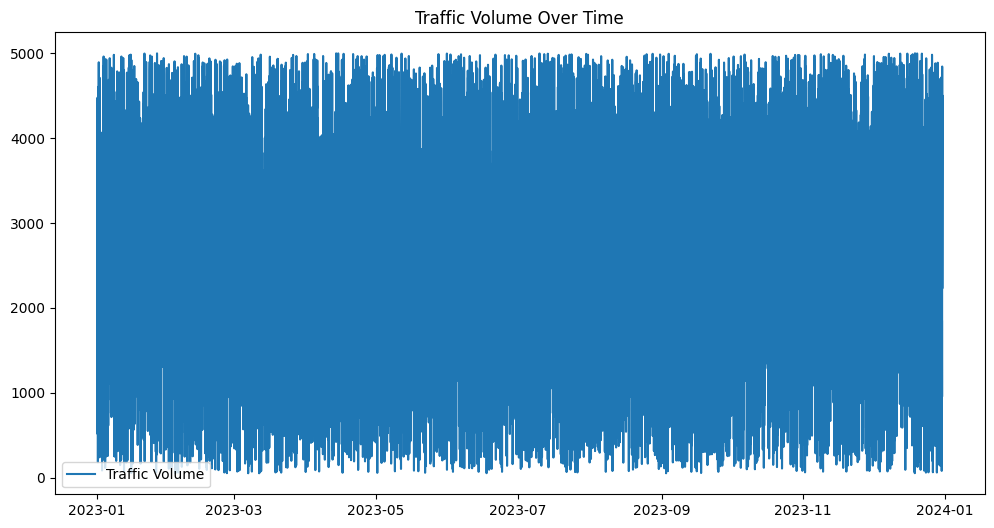

In [64]:

traffic_data['timestamp'] = pd.to_datetime(traffic_data['timestamp'])
traffic_data.set_index('timestamp', inplace=True)

plt.figure(figsize=(12, 6))
plt.plot(traffic_data['traffic_volume'], label='Traffic Volume')
plt.title('Traffic Volume Over Time')
plt.legend()
plt.show()


**Step 3: Data Preprocessing**

In [65]:

traffic_data.fillna(method='ffill', inplace=True)

q1 = traffic_data['traffic_volume'].quantile(0.25)
q3 = traffic_data['traffic_volume'].quantile(0.75)
iqr = q3 - q1
traffic_data = traffic_data[(traffic_data['traffic_volume'] >= q1 - 1.5 * iqr) &
                             (traffic_data['traffic_volume'] <= q3 + 1.5 * iqr)]


traffic_data['hour'] = traffic_data.index.hour
traffic_data['day_of_week'] = traffic_data.index.dayofweek
traffic_data['month'] = traffic_data.index.month


**Step 4: Train-Test Split**

In [66]:
train_data, test_data = train_test_split(traffic_data, test_size=0.2, shuffle=False)


X_train = train_data[['hour', 'day_of_week', 'month']]
y_train = train_data['traffic_volume']
X_test = test_data[['hour', 'day_of_week', 'month']]
y_test = test_data['traffic_volume']

**Step 5: Baseline Model (ARIMA/SARIMA)**


In [28]:

model = ARIMA(y_train, order=(5, 1, 0))
arima_model = model.fit()


arima_preds = arima_model.forecast(steps=len(y_test))


In [29]:
print("MAE:", mean_absolute_error(y_test, arima_preds))
print("RMSE:", np.sqrt(mean_squared_error(y_test, arima_preds)))


MAE: 1253.2822243553385
RMSE: 1446.9500139392035


In [30]:

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(traffic_data[['traffic_volume']])


def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 24
X, y = create_sequences(scaled_data, seq_length)


X_train, X_test = X[:len(train_data)], X[len(train_data):]
y_train, y_test = y[:len(train_data)], y[len(train_data):]


In [90]:
model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=10, batch_size=32)


Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 0.2626
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0964
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0957
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0813
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0826
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0898
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0799
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0853
Epoch 9/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0825
Epoch 10/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0859


In [32]:
lstm_preds = model.predict(X_test)
lstm_preds = scaler.inverse_transform(lstm_preds)

print("MAE:", mean_absolute_error(y_test, lstm_preds))
print("RMSE:", np.sqrt(mean_squared_error(y_test, lstm_preds)))


54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
MAE: 2523.211583564342
RMSE: 2523.2805889416272


Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - loss: 0.3405 - val_loss: 0.2171
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.1418 - val_loss: 0.1079
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0994 - val_loss: 0.1029
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0844 - val_loss: 0.0953
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0852 - val_loss: 0.0958
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0843 - val_loss: 0.0940
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0864 - val_loss: 0.0946
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0812 - val_loss: 0.0940
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0812 - val_loss: 0.0950
Epoch 10/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0867 - val_loss: 0.0935
Epoch 11/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0888 - val_loss: 0.0941
Epoch 12/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.

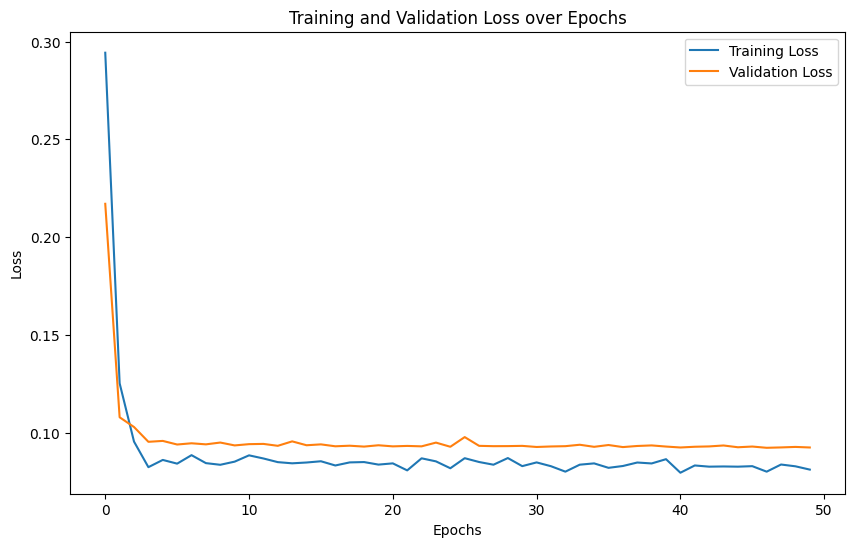

In [89]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import numpy as np

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(traffic_data[['traffic_volume']])


def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 24
X, y = create_sequences(scaled_data, seq_length)

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')


history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))


plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


**Step 6: Incorporate External Factors**

In [33]:
weather_data = pd.read_csv('/content/weather_data.csv')

In [34]:
weather_data.head()

,timestamp,temperature,humidity,weather_condition
0,2023-01-01 00:00:00,3.2,22.7,Cloudy
1,2023-01-01 01:00:00,36.7,60.2,Rainy
2,2023-01-01 02:00:00,26.0,45.1,Rainy
3,2023-01-01 03:00:00,27.7,34.4,Sunny
4,2023-01-01 04:00:00,1.0,80.0,Sunny


from matplotlib import pyplot as plt
_df_0['temperature'].plot(kind='hist', bins=20, title='temperature')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['humidity'].plot(kind='hist', bins=20, title='humidity')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_2.groupby('timestamp').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_3.groupby('weather_condition').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='temperature', y='humidity', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['timestamp']
  ys = series['temperature']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_5.sort_values('timestamp', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('timestamp')):
  _plot_series(series, series_name, i)
  fig.legend(title='timestamp', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('timestamp')
_ = plt.ylabel('temperature')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['timestamp']
  ys = series['temperature']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_6.sort_values('timestamp', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('weather_condition')):
  _plot_series(series, series_name, i)
  fig.legend(title='weather_condition', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('timestamp')
_ = plt.ylabel('temperature')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['timestamp']
  ys = series['humidity']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_7.sort_values('timestamp', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('timestamp')):
  _plot_series(series, series_name, i)
  fig.legend(title='timestamp', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('timestamp')
_ = plt.ylabel('humidity')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['timestamp']
  ys = series['humidity']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('timestamp', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('weather_condition')):
  _plot_series(series, series_name, i)
  fig.legend(title='weather_condition', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('timestamp')
_ = plt.ylabel('humidity')

from matplotlib import pyplot as plt
_df_9['temperature'].plot(kind='line', figsize=(8, 4), title='temperature')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_10['humidity'].plot(kind='line', figsize=(8, 4), title='humidity')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['weather_condition'].value_counts()
    for x_label, grp in _df_11.groupby('timestamp')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('timestamp')
_ = plt.ylabel('weather_condition')

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_12['timestamp'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_12, x='temperature', y='timestamp', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_13['weather_condition'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_13, x='temperature', y='weather_condition', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_14['timestamp'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_14, x='humidity', y='timestamp', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_15['weather_condition'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_15, x='humidity', y='weather_condition', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [74]:
import pandas as pd

traffic_data = pd.read_csv('/content/traffic_dataset.csv')


weather_data = pd.read_csv('/content/weather_data.csv')

traffic_data['timestamp'] = pd.to_datetime(traffic_data['timestamp'], errors='coerce')
weather_data['timestamp'] = pd.to_datetime(weather_data['timestamp'], errors='coerce')


traffic_data = traffic_data.dropna(subset=['timestamp'])
weather_data = weather_data.dropna(subset=['timestamp'])


merged_data = traffic_data.merge(weather_data, on='timestamp', how='left')


merged_data.to_csv('merged_data1.csv', index=False)


print(merged_data.head())


            timestamp  traffic_volume weather  is_holiday  temperature  \
0 2023-01-01 00:00:00             910  Cloudy           0          3.2   
1 2023-01-01 01:00:00            3822   Rainy           0         36.7   
2 2023-01-01 02:00:00            3142   Rainy           1         26.0   
3 2023-01-01 03:00:00             516   Sunny           0         27.7   
4 2023-01-01 04:00:00            4476   Sunny           0          1.0   

   humidity weather_condition  
0      22.7            Cloudy  
1      60.2             Rainy  
2      45.1             Rainy  
3      34.4             Sunny  
4      80.0             Sunny  


In [75]:
from google.colab import files

merged_data.to_csv('merged_data1.csv', index=False)
files.download('merged_data1.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [78]:
merged_data.head(10)

,timestamp,traffic_volume,weather,is_holiday,temperature,humidity,weather_condition
0,2023-01-01 00:00:00,910,Cloudy,0,3.2,22.7,Cloudy
1,2023-01-01 01:00:00,3822,Rainy,0,36.7,60.2,Rainy
2,2023-01-01 02:00:00,3142,Rainy,1,26.0,45.1,Rainy
3,2023-01-01 03:00:00,516,Sunny,0,27.7,34.4,Sunny
4,2023-01-01 04:00:00,4476,Sunny,0,1.0,80.0,Sunny
5,2023-01-01 05:00:00,3494,Sunny,0,12.2,36.4,Sunny
6,2023-01-01 06:00:00,3221,Sunny,0,20.9,75.0,Sunny
7,2023-01-01 07:00:00,2969,Snowy,0,28.5,47.9,Snowy
8,2023-01-01 08:00:00,180,Rainy,0,-4.8,60.9,Rainy
9,2023-01-01 09:00:00,1735,Sunny,0,38.1,94.7,Sunny


Mean Absolute Error (MAE): 1348.62
Root Mean Squared Error (RMSE): 1348.62
R-Squared: nan


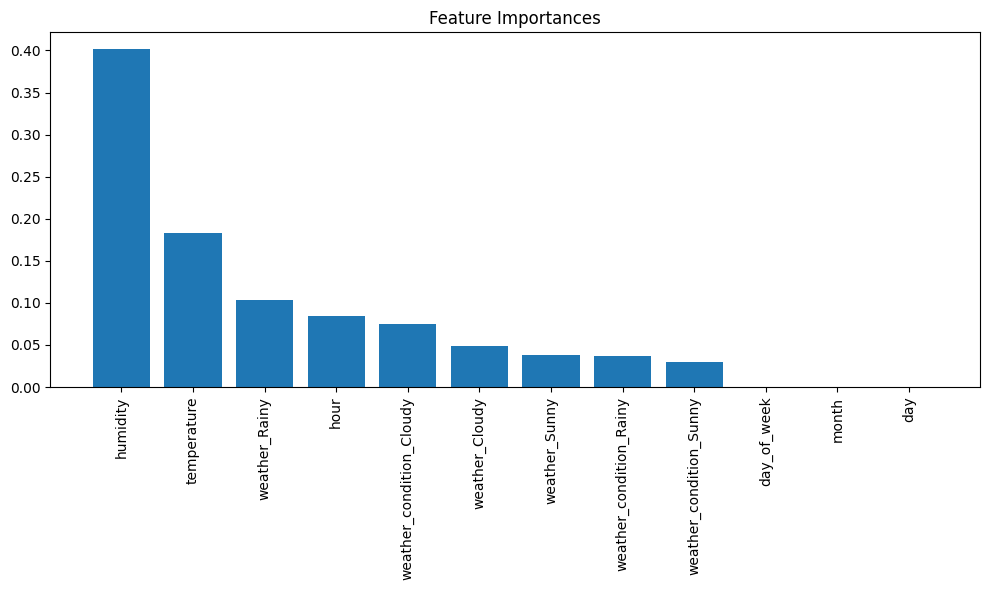

In [69]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


merged_data = pd.read_csv('/content/merged_data.csv')  # Replace with your file path
merged_data['timestamp'] = pd.to_datetime(merged_data['timestamp'])


merged_data = merged_data.dropna()


merged_data['hour'] = merged_data['timestamp'].dt.hour
merged_data['day'] = merged_data['timestamp'].dt.day
merged_data['month'] = merged_data['timestamp'].dt.month
merged_data['day_of_week'] = merged_data['timestamp'].dt.dayofweek


X = merged_data.drop(['timestamp', 'traffic_volume'], axis=1)
y = merged_data['traffic_volume']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


numerical_features = ['hour', 'day', 'month', 'day_of_week', 'temperature', 'humidity']
categorical_features = ['weather', 'weather_condition']


numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

model.fit(X_train, y_train)


y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-Squared: {r2}")


import matplotlib.pyplot as plt

feature_names = numerical_features + list(model.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out())
importances = model.named_steps['regressor'].feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

In [38]:
!pip install dash

In [4]:
!pip install dash plotly

import dash
from dash import dcc, html, Input, Output
import plotly.express as px
import pandas as pd
import numpy as np
from datetime import datetime, timedelta


def generate_real_time_data():
    now = datetime.now()
    timestamps = pd.date_range(start=now - timedelta(hours=5), periods=6, freq='H')  # Last 5 hours + current hour
    traffic_volume = np.random.randint(100, 5000, size=6)
    return pd.DataFrame({'timestamp': timestamps, 'traffic_volume': traffic_volume})


traffic_data = generate_real_time_data()


class DummyModel:
    def predict(self, X):

        return np.random.randint(100, 5000, size=len(X))


your_model = DummyModel()


threshold = 4000


app = dash.Dash(__name__)


app.layout = html.Div(children=[
    html.H1(children="Real-Time Traffic Flow Dashboard"),


    html.Div("Real-time Traffic Data Monitoring", style={'margin-bottom': '20px'}),


    dcc.Graph(id='traffic-graph'),


    dcc.Interval(
        id='interval-component',
        interval=60 * 1000,
        n_intervals=0
    )
])


@app.callback(
    Output('traffic-graph', 'figure'),
    [Input('interval-component', 'n_intervals')]
)
def update_graph(n):
    global traffic_data


    new_data = generate_real_time_data()
    traffic_data = pd.concat([traffic_data, new_data]).drop_duplicates(subset=['timestamp']).reset_index(drop=True)


    traffic_data_sorted = traffic_data.sort_values(by='timestamp')


    future_timestamps = pd.date_range(start=traffic_data_sorted['timestamp'].iloc[-1] + timedelta(hours=1), periods=5, freq='H')


    predicted_volume = your_model.predict(future_timestamps)


    fig = px.line(traffic_data_sorted, x='timestamp', y='traffic_volume', title="Real-Time Traffic Volume")
    fig.add_scatter(x=future_timestamps, y=predicted_volume, mode='lines', name='Predicted')


    if predicted_volume[-1] > threshold:
        fig.update_layout(
            annotations=[
                dict(
                    text="High traffic alert!",
                    x=future_timestamps[-1],
                    y=predicted_volume[-1],
                    showarrow=True,
                    arrowhead=1,
                    ax=-50,
                    ay=-50
                )
            ]
        )

    return fig


if __name__ == '__main__':
    app.run_server(debug=True)


<IPython.core.display.Javascript object>